## NTDS project notebook - Amazon Electronic Products Network Analysis

`Süha Kagan Köse - Tao Sun - Xiangzhe Meng - Xingce Bao`

In [1]:
import pandas as pd
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
pd.options.mode.chained_assignment = None

## Index

1. [Data loading](#Data-loading)
2. [Data pre-processing for electronic product reviews dataset](#Data-pre-processing-for-electronic-product-reviews-dataset)
3. [Data pre-processing for electronic product metadata dataset](#Data-pre-processing-for-electronic-product-metadata-dataset)
4. [Data after pre-processing](#Data-after-pre-processing)
5. [Study on Macbook and Surface](#Study-on-Macbook-and-Surface)
    1. [Use only 'also_bought'](#1.--Use-only-the-information-of-'also_bought')
    2. [Use both 'also_bought' and 'reviewer' ](#2.-Use-both-the-information-of-'also_bougtht'-and-'reviewer')
    3. [Network Graphs for Mackbook and surface related products comparison](#3.-Network-Graphs-for-Mackbook-and-surface-related-products-comparison)
6. [Study on Macbook, Surface and ThinkPad](#Study-on-Macbook,-Surface-and-ThinkPad)

**`Attention`**: If you want to execute our analysis part, you can directly **start from the part 4** since it takes some time during the data loading and pre-processing. As we have generated pickle files for the clean and useful data, you can load it from the part 4.

---
## Data loading

In this project, we choose to use the subset **Electronics** of [**Amazon Product Dataset**](http://jmcauley.ucsd.edu/data/amazon/links.html), provided by Julian McAuley, UCSD. This dataset includes **product metadata** (descriptions, category information, price, brand, and image features), and links (also viewed/ also bought graphs), and millions of **reviews**(ratings, text, helpful- ness votes) spanning from May 1996 to July 2014.

In this part, we load the two initial datasets into two dataframes.

- **`df_product`**: contains all the electronic products' information.
- **`df_review`**: contains all the reviews concerning the electronic products.

In [2]:
# useful functions for data loading
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
# load data
df_product = getDF('data/meta_Electronics.json.gz')
df_review = getDF('data/reviews_Electronics_5.json.gz')

# generate pickle files in order to save the future laoding time
df_product.to_pickle('data/origin_product.pkl')
df_review.to_pickle('data/origin_review.pkl')

NameError: name 'getDF' is not defined

Here are the structures of the two dataframes:

In [4]:
df_product.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [5]:
df_review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


---
## Data pre-processing for electronic product reviews dataset

In this part, we do some data cleaning and preprocessing works for electronic product reviews dataset. 

#### Collect all reviewers' ID for each product

We collect all the reviewer's IDs for each product and arrange them in a new dataframe shown as below.

Actually, we have chosen a **5-core structure** subset for review dataset, which means the data in which all users and items have at least 5 reviews. Therefore, for each asin, there are at least 5 related reviewer' IDs.

In [6]:
# group by asin(product ID) and save all reviewer's IDs for each asin into a list
df_product_reviewer = pd.DataFrame(df_review.groupby(['asin'])['reviewerID'].apply(list))
df_product_reviewer.to_pickle('data/product_reviewer.pkl')

In [7]:
df_product_reviewer.head()

,reviewerID
asin,
0528881469,"[AO94DHGC771SJ, AMO214LNFCEI4, A3N7T0DY83Y4IG,..."
0594451647,"[A2JXAZZI9PHK9Z, A2P5U7BDKKT7FW, AAZ084UMH8VZ2..."
0594481813,"[A7S2B0I67WNWB, A3HICVLF4PFFMN, ANSKSPEEAKY7S,..."
0972683275,"[A20XXTXWF2TCPY, A2IDCSC6NVONIZ, A1EDI0X3GI1SK..."
1400501466,"[A3LDPF5FMB782Z, A9HYSJ3D0D6I2, A3EOHF2YSVZA9L..."


In [8]:
print("There are {} electronic products who have at least 5 reviews in our dataset.".format(df_product_reviewer.shape[0]))

There are 63001 electronic products who have at least 5 reviews in our dataset.


#### Collect all reviewers' ID

In this part, we collect all the IDs of the reviewers who have commented on at least one product in our dataset.

In [9]:
reviewers = set([x for list_ in df_product_reviewer['reviewerID'].values for x in list_])

In [10]:
print("There are {} reviewers who have commented on at least on product in our dataset.".format(len(reviewers)))

There are 192403 reviewers who have commented on at least on product in our dataset.


---
## Data pre-processing for electronic product metadata dataset

In this part, we do some data cleaning and preprocessing works for electronic products dataset. 

First of all, we drop the following columns which are useless for our reserach: **imUrl, salesRank, brand, description, categories, title, price**.

Then, We plan to discover the inner connection among the different electronic products. The column **related** is very essential for us, since it can contain **also_viewed, also_bought, bought_together, buy_after_viewing** product asins. However, these 4 categories are not always presented at the same time for each product.

We found that there exists some Nan values in this column. Hence, we are supposed to drop them out.

In [11]:
# Drop useless columns
df_product.drop(['imUrl','salesRank','brand','description','categories','title','price'],axis=1,inplace=True)

# Drop rows which related column is Nan value
df_product = df_product[df_product['related'].notnull()]

# update product pickle file
df_product.to_pickle('data/product_with_related.pkl')

# Collect all electronic products' asin
product_asin = df_product['asin'].values

Now, we decided to only keep products which present in both metadata and review datasets. First of all, we checked if all products who prossess reviews have the corresponding product information in metadata dataset. 

In [12]:
# get all review product asins 
product_with_review_asin = df_product_reviewer.index.values

# get all metadata product asins 
product_asin = df_product['asin'].values

if (list(set(product_asin) & set(product_with_review_asin)) == list(product_with_review_asin)):
    print("All products who possess reviews have the corresponding product description in metadata dataset!")
else:
    print("There exists some review products which is not in metadata dataset.")

There exists some review products which is not in metadata dataset.


As there are some products who are not in both two datasets, we are supposed to drop these products from the two datasets and only keep the intersection.

In [13]:
num_product = len(list(set(product_asin) & set(product_with_review_asin)))
print("There are {} electronic products in both metadata and review datasets".format(num_product))

There are 60682 electronic products in both metadata and review datasets


In [14]:
# Clean review dataset and update pickle file
product_to_keep_asin = list(set(product_asin) & set(product_with_review_asin))
df_product_reviewer_new = df_product_reviewer.loc[product_to_keep_asin]
df_product_reviewer_new.to_pickle('data/review_intersection.pkl')

# Clean product dataset and update pickle file
df_product.set_index(['asin'],inplace=True)
df_product = df_product.loc[product_to_keep_asin]
df_product.to_pickle('data/product_intersection.pkl')

#### Create also_bought relation dataframe

At the very beginning, we planned to create a network to present the relationship among one products and its potential also bought products. Therfore, we added a new column **also_bought** for those products who possess also_bought products which are also in metadata dataset.

In [15]:
df_product = pd.read_pickle('data/product_intersection.pkl')
product_asin = df_product.index.values

In [16]:
def also_bought(x):
    # verify if the product has also_bought atteibute
    if 'also_bought' in x.keys():
        temp = []
        for asin in x['also_bought']:
            # verify the also_bought product is also in metadata dataset
            if asin in product_asin:
                temp.append(asin)
        return temp
    else:
        return []

In [17]:
df_product['also_bought'] = df_product['related'].apply(lambda x: also_bought(x))

# update pickle file after adding two new columns
df_product.to_pickle('data/product_also_bought.pkl')

df_product.head()

,related,also_bought
asin,,
B0083S3NC8,"{'also_bought': ['B005GU0DXS', 'B0086I58IW', '...","[B007W1KES8, B005KQ0S8S, B007W1KEFG, B005F15N2..."
B0047FHOWG,"{'also_bought': ['B0019SHZU0', 'B002ZIMEMW', '...","[B0019SHZU0, B002ZIMEMW, B002HJ9PTO, B004AZ38Z..."
B0067SJC80,"{'also_bought': ['B000X1R5HM', 'B004MU8VCS', '...","[B000X1R5HM, B004MU8VCS, B002YIG9AQ, B005CTCD6..."
B002WQP2IA,"{'also_bought': ['B000U0HAR6', 'B005QCPG9C', '...","[B000U0HAR6, B000068O4E, B000068O4C, B00356J8K..."
B006IC4YZQ,"{'also_bought': ['B00ICS8OF0', 'B004OEBMAK', '...","[B001G54ILA, B005SDWP3O, B0036QL1JY]"


As there are some products who don't have any also_bought products, we dropped them out.

In [18]:
df_product_bought = df_product[['also_bought']]

# drop products who don't have also_bought related products
df_product_bought['also_bought'] = df_product_bought['also_bought'].apply(lambda x: 'unknown' if x == [] else x)
df_product_bought = df_product_bought[~(df_product_bought['also_bought'] == 'unknown')]

# update also_bought column since we dropped some product from the dataframe
also_bought_index = df_product_bought.index.values
for asin in also_bought_index:
    new_related = []
    for related in df_product_bought.loc[asin].also_bought:
        # verify if the also_bought product is still in metadata dataset
        if related in also_bought_index:
            new_related.append(related)
    # update the also_bought column value
    df_product_bought.loc[asin].also_bought = new_related
    
# update pickle file
df_product_bought.to_pickle('data/product_also_bought.pkl')

Now, we should update review dataset as well since we have just drop some products from metadata dataset.

In [19]:
# update review dataset & only keep reviews concerning the products which exist in new product dataset
# collect all product asin
all_product = df_product_bought.index.values

# load original review dataset
df_review = pd.read_pickle('data/review_intersection.pkl')

# keep reviews whose concerning product is in new product list
df_review_bought = df_review.loc[all_product]

# update review dataset
df_review_bought.to_pickle('data/review_also_bought.pkl')

Until now, we finished all the data preprocessing work and get two useful dataset. We store them as two pickle files:

- **`product_also_bought.pkl`**: contains all the product information and also_bought related product asin.
- **`review_also_bought.pkl`**: contains all the reviews concerning the products present in the first metadata dataset.

---
## Data after pre-processing

In this part, you can directly load all the clean and useful data for the usage of further research and analysis part.

In [3]:
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

In [4]:
print("We keep {} electronic products to conduct our project.".format(df_product.shape[0]))

We keep 43276 electronic products to conduct our project.


---
## Study on Macbook and Surface

### Build two groups of data
In this part, we build two groups of data, mac group and surface group.
- In the group dataframe contains information about the product and 'also_bought' of it.
- Choose one **core** product of each group.
- The **1st** layer: Add all of the 'also_bought' products of the core.
- The **2nd** layer: Add all of the 'also_bought' products of the 1st layer.
- ...

In this project, we only add 2 layers of data.

In [5]:
def get_all_related_asin_from_list_asin(list_asin):
    res = []
    for asin in list_asin:
        res.extend(df_product.loc[asin]['also_bought'])
    res = list(set(res))
    return res

'B005CWJB5G' is the asin for Macbook Air.

In [6]:
# Macbook
nb_layer = 2
df_mac = df_product[df_product.index == 'B005CWJB5G']
list_asin = ['B005CWJB5G']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_mac = pd.concat([df_mac,df_product.loc[index]])
    list_asin = index
df_mac = df_mac.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of mac.'.format(df_mac.shape[0]))

We have 743 products in the group of mac.


'B00FG7MVJU' is the asin for Surface.

In [7]:
# Surface
nb_layer = 2
df_surface = df_product[df_product.index == 'B00FG7MVJU']
list_asin = ['B00FG7MVJU']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_surface = pd.concat([df_surface,df_product.loc[index]])
    list_asin = index
df_surface = df_surface.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of surface.'.format(df_surface.shape[0]))

We have 499 products in the group of surface.


We note that there are some duplicates of two groups.

In [8]:
dupasin = list(set(df_mac.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in two groups.'.format(len(dupasin)))

We have 134 duplicate products in two groups.


To balance two groups of data, we treat all duplicates as data in the group of surface. Thus, we drop all of the duplicates from the mac group.

In [9]:
df_mac_new = df_mac.set_index('asin').drop(dupasin)
n_mac = df_mac_new.shape[0]
print('Now, we have {} products in the group of mac.'.format(n_mac))

Now, we have 609 products in the group of mac.


Merge two groups of data together into one DataFrame.

We now know that the first `n_mac` products are in the group of mac while the others are in the group of surface.

In [10]:
df_all = pd.concat([df_mac_new.reset_index(), df_surface])
print('We have {} products in all.'.format(df_all.shape[0]))

We have 1108 products in all.


In [11]:
df_all.head()

,asin,also_bought
0,B005CWJB5G,"[B004R6J2V6, B007FL7GGS, B0077EVNY4, B008AL9VX..."
1,B007FL7GGS,"[B008BWL4MW, B008AKNIQ0, B009MKBYPE, B0077EVNY..."
2,B004IVAPM0,"[B0085D7U20, B004J0IMYS, B004IV6FYW, B004IV8Y5..."
3,B004YLCFCM,"[B004R6J2KW, B008AL9VXI, B003XIJ3MW, B004YLCH0..."
4,B004YLCHLQ,"[B004R6J2KW, B008AL9VXI, B003XIJ3MW, B004YLCH0..."


### Build the graph
In this part, we use the data we selected above to build the product graph.

- **Node**: Product


- **Edge**: If A is the 'also_bought' of B or B is the 'also_bought' of A, connect A and B.


- **Weight**: Below we implement two ways to calculate the weight of edge.

    - Use only the information of 'also_bougtht': $$Weight = \# Shared\_Neighbors$$
    
    - Use both the information of 'also_bougtht' and 'reviewer':$$Weight = 0.8 * \frac{\# Shared\_Neighbors}{MaxShared\_Neighbors} + 0.2 * \frac{\# Shared\_Reviewers}{MaxShared\_Neighbors}$$
    
    
- **Similarity**: For the implementation of spectral graph theory, we also need define the similarity between two products. The similarity is calculated as below:
$$Similarity = \frac{Weight}{MaxWeight}$$

In [12]:
import networkx as nx

### 1.  Use only the information of 'also_bought'

In [13]:
G = nx.Graph()
G.add_nodes_from(df_all.asin.values)

In [14]:
for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        set_len = len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought']))
        G.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=set_len)

In [15]:
A = nx.adjacency_matrix(G,weight='weight')
A.todense()

matrix([[0, 0, 0, ..., 2, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 2, 0, 5],
        ..., 
        [2, 1, 2, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 5, ..., 2, 0, 0]], dtype=int32)

### **`Spectral Graph Theory`**

Calculate the **Similarity Matrix** by normalizing the maximum as 1

In [16]:
A.max()

47

In [17]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

Keep the **TOP K Neighbors**.

We first use K = 300.

In [18]:
weights = similar.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

In [19]:
weights

array([[ 0.        ,  0.        ,  0.        , ...,  0.04255319,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0212766 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.04255319,
         0.        ,  0.10638298],
       ..., 
       [ 0.04255319,  0.0212766 ,  0.04255319, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.10638298, ...,  0.        ,
         0.        ,  0.        ]])

Calculate the **Laplacian**.

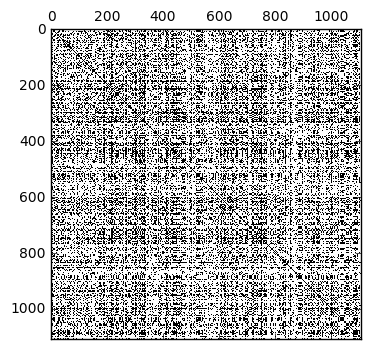

In [20]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue decomposition** of the Laplacian.

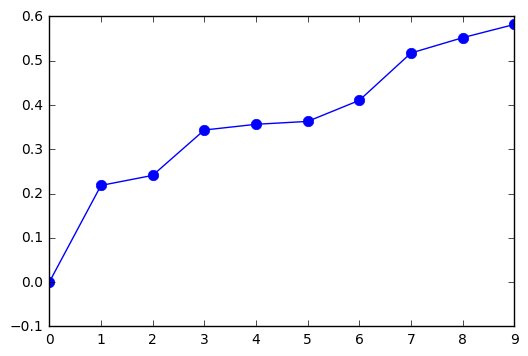

In [21]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Ground truth**: we label all of data in mac group as 0 and those in surface group as 1.

In [22]:
labels = np.ones(A.shape[0])
labels[0:n_mac] = 0

**Plot** the groud truth and the prediction based on spectral graph theory.

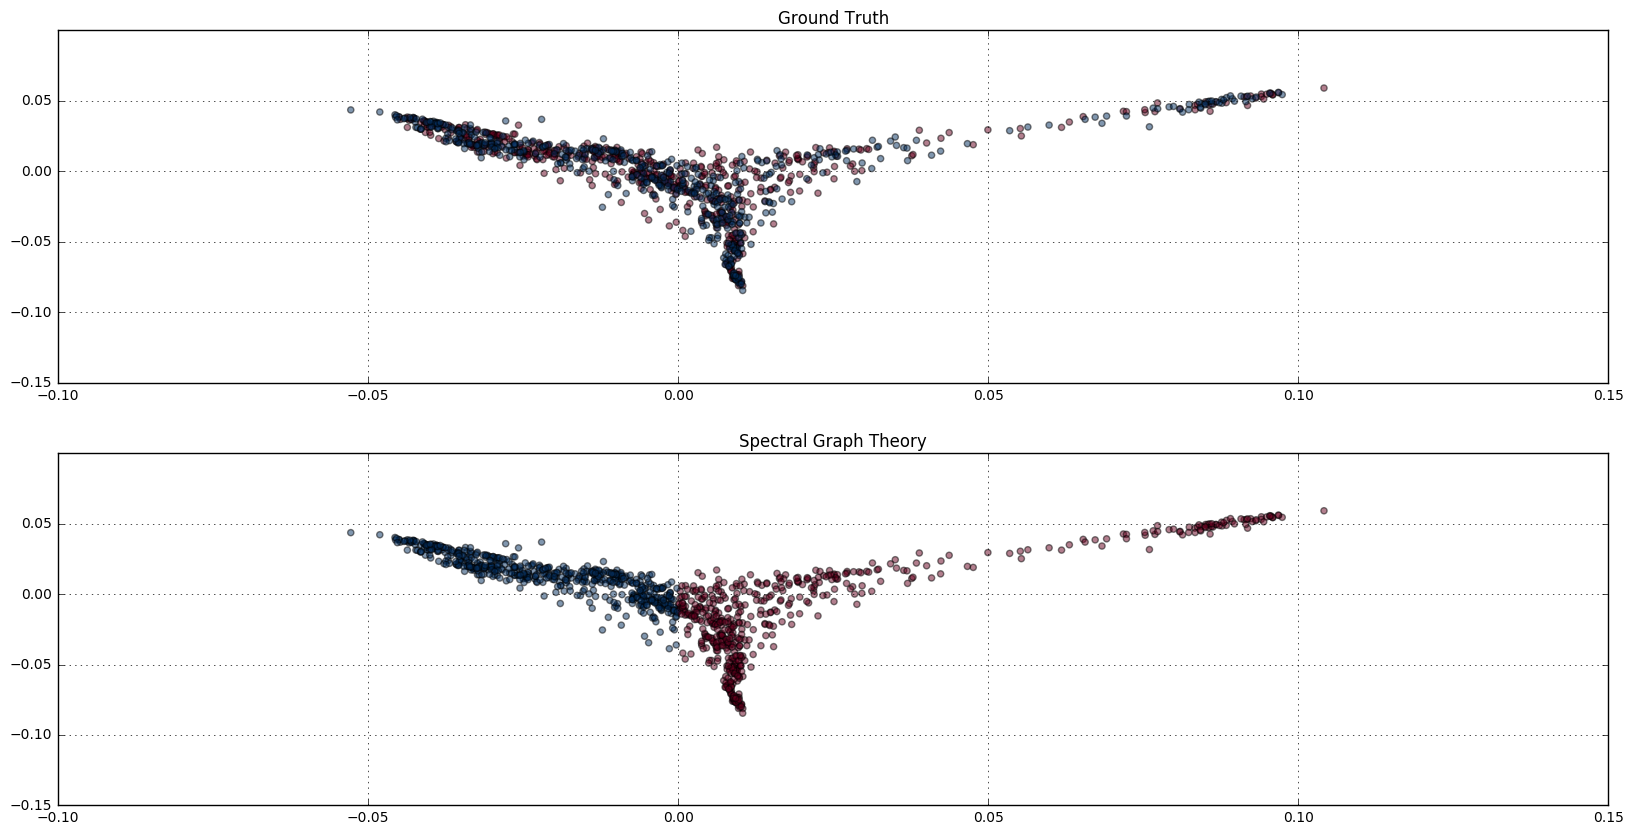

In [28]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=(x1<0), cmap='RdBu', alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error rate**

In [29]:
np.sum((x1<0) != labels)/len(labels)

0.52256317689530685

### **`Transductive Learning`**

In [25]:
# Ground truth.
x = np.ones(len(G.nodes))
x[0:n_mac] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=len(G.nodes)) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)

In [26]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    
    M = np.diag(y!=0)
    
    x_star = np.linalg.solve(M+alpha*laplacian, M.dot(y))
    
    x_pred = np.ones(len(G.nodes))
    x_pred[x_star<0] = -1
    
    return x_pred, x_star

x_pred, x_star = solve(y, alpha=1)

# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred), 1)

# Error rate.
#err = np.sum(np.abs(x - x_pred))
err = np.sum(x != x_pred)
print('{} errors ({:.2%})'.format(err, err/len(G.nodes)))

455 errors (41.06%)


In [27]:
alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y = prepare_observations(p)
    x_pred, _ = solve(y, alpha)
    err = np.sum(x != x_pred)
    print('{}: {:6.2%}'.format(p, err/len(G.nodes)))

0.1: 41.16%
0.3: 32.04%
0.5: 22.47%
0.7: 13.18%
0.9:  4.69%


**Plot**

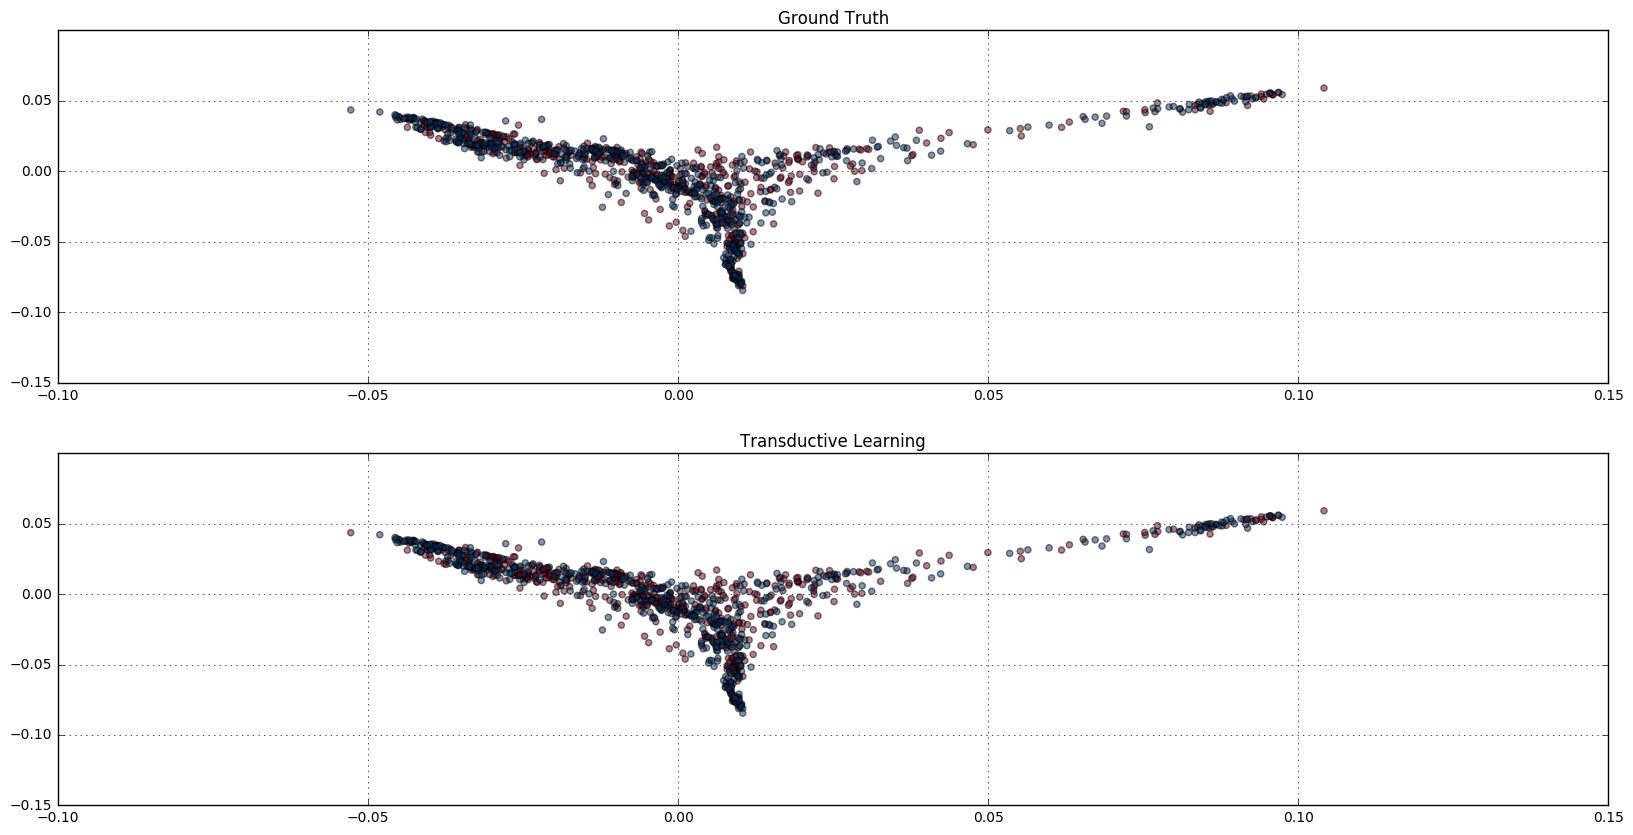

In [30]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=x_pred, cmap='RdBu', alpha=0.5)
ax[1].set_title('Transductive Learning')
ax[1].grid()

### 2. Use both the information of 'also_bought' and 'reviewer'

In [31]:
df_review.head()

,reviewerID
asin,
B0083S3NC8,"[A18I2DO90GZCQY, A2C4BO8UURNWNN, A2RF9FHC4HC3J..."
B0047FHOWG,"[A3OTFTP2WVZVQY, A10KIQXOE926FN, A1Q165PZVZS34..."
B0067SJC80,"[A3QLALFN0WGF87, A395EVHF1TAQN0, AOEDXOKYPII2Z..."
B002WQP2IA,"[AN3ILH8NOGNH4, A3FGRP5N72WES1, ADN4437IJDIPP,..."
B006IC4YZQ,"[A3W3PWGZ36249Y, AZLDKR28KT3FB, A3M3DL4G9NS3Z2..."


Select the review information of data in our DataFrame.

In [32]:
df_review_chosen = df_review.loc[df_all.asin].reset_index()

Build the graph as we did above.

In [33]:
GB = nx.Graph()
GB.add_nodes_from(df_all.asin.values)
bou_len_list = [] # list for # shared also_bought
rer_len_list = [] # list for # shared reviewer

for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        bou_len_list.append(len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought'])))
        rer_len_list.append(len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID'])))

In [34]:
# Study the basics of two lists
df_bou_rer = pd.DataFrame({'b': bou_len_list, 'r': rer_len_list})
pd.DataFrame([df_bou_rer[df_bou_rer.b>0].describe().b, df_bou_rer[df_bou_rer.r>0].describe().r])

,count,mean,std,min,25%,50%,75%,max
b,268866.0,4.073036,4.454166,1.0,1.0,2.0,5.0,47.0
r,47420.0,1.953838,3.370354,1.0,1.0,1.0,2.0,211.0


In [35]:
bou_len_list.reverse()
rer_len_list.reverse()
for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        bou_len = bou_len_list.pop()/47
        rer_len = rer_len_list.pop()/211
        # The weight is manually chosen now and may need to be modified
        GB.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=0.8*bou_len+0.2*rer_len)

In [36]:
B = nx.adjacency_matrix(GB,weight='weight')
B.todense()

matrix([[ 0.        ,  0.        ,  0.00094787, ...,  0.03404255,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.01702128,
          0.        ,  0.        ],
        [ 0.00094787,  0.        ,  0.        , ...,  0.03499042,
          0.        ,  0.08794998],
        ..., 
        [ 0.03404255,  0.01702128,  0.03499042, ...,  0.        ,
          0.        ,  0.03404255],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.08794998, ...,  0.03404255,
          0.        ,  0.        ]])

### `Basic properties of graph`

In [38]:
node_number = len(GB.nodes())
print('My network has {} nodes.'.format(node_number))
B_rw = B.copy()
B_rw[B>0] = 1
edge_number = int(np.sum(B_rw)/2)
print('My network has {} edges.'.format(edge_number))

My network has 1108 nodes.
My network has 287211 edges.


In [39]:
max_edge = node_number*(node_number-1)/2
print (max_edge)
rate = 1.0*edge_number/max_edge
print ("The rate of the real edge/max number of edge")
print (rate)

613278.0
The rate of the real edge/max number of edge
0.46832105505170574


The maximum number of links in a network with $N$ nodes is $L_{max}=N(N-1)/2$.Now we have about 50% of them.This graph is not very sparse.

**Degree distribution**

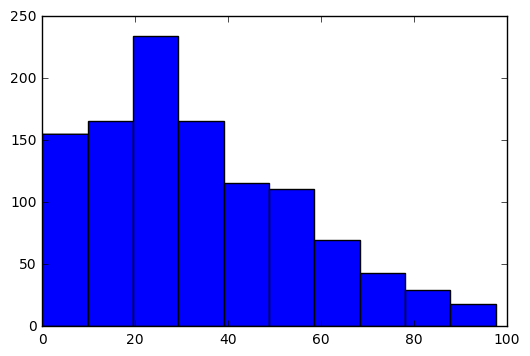

In [42]:
d = B.todense().sum(axis=1)
plt.hist(d);

**The average degree is below**

In [44]:
d_avg = np.sum(d)/len(d)
print (d_avg)

33.8047615061


**Graph generate models**

Now wegenerate Erdős–Rényi and Barabási-Albert graph using NetworkX and compare with our graph

In [45]:
er=nx.erdos_renyi_graph(node_number,rate)
ba=nx.barabasi_albert_graph(node_number,int(edge_number/node_number))

In [46]:
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))

My Erdős–Rényi network has 1108 nodes.
My Erdős–Rényi network has 286751 edges.
My Barabási-Albert network has 1108 nodes.
My Barabási-Albert network has 219891 edges.


In [47]:
giant_GB = max(nx.connected_component_subgraphs(GB), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_GB.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

1108
1108
1108


The graph is all fully connected.

In [48]:
print (nx.average_clustering(GB))
print (nx.average_clustering(er))
print (nx.average_clustering(ba))

1.0
0.4676481924162453
0.4617679466529978


From the way we construct the graph, we can easily see that the graph is fully connected.Now we proved that.And also we can see that the generate models can't mimic the clustering coeffcient of real graph.

### `Spectral Graph Theory`

**Similarity Matrix**

In [77]:
B.max()

0.80000000000000004

In [78]:
similarB = B.todense()/B.max()
np.fill_diagonal(similarB,0)

**TOP K Neighbors**

In [130]:
weights = similarB.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

**Calculate Laplacian**

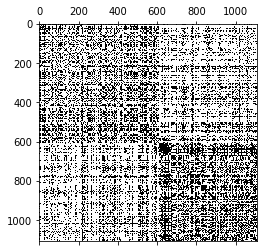

In [131]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue Decomposition**

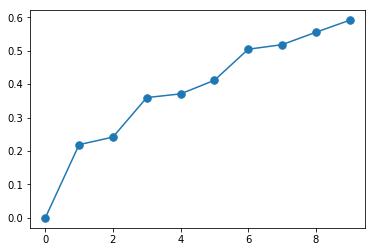

In [132]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Plot**

In [133]:
labels = np.ones(B.shape[0])
labels[0:n_mac] = 0

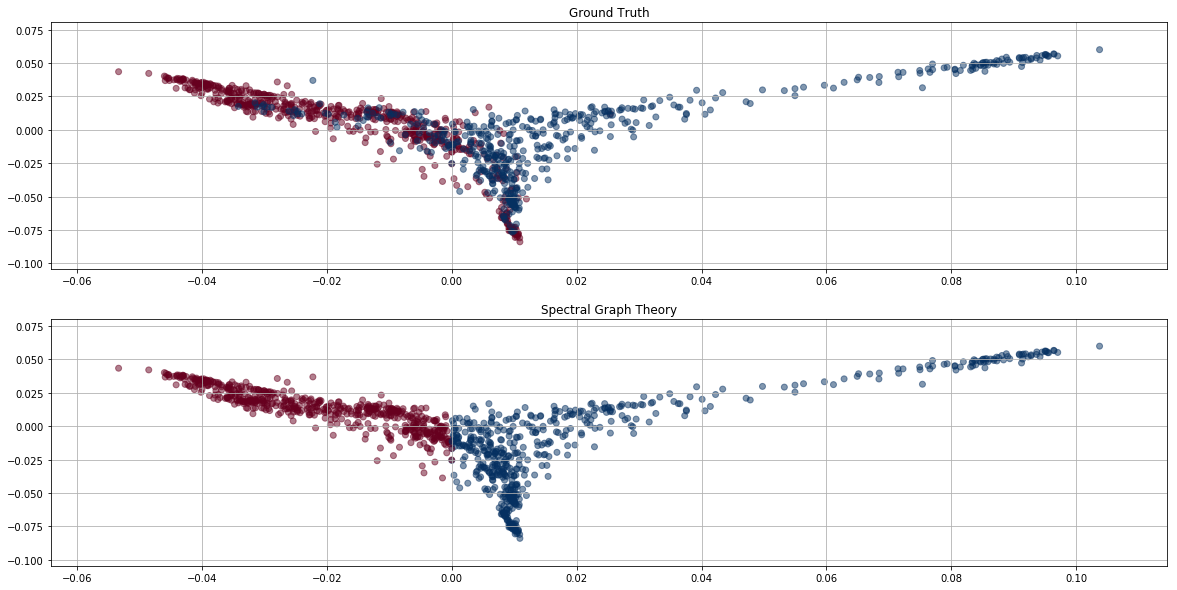

In [135]:
x2 = eigenvectors[:,1]
y2 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x2, y2, c=labels, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x2, y2, c=(x2>0), cmap='RdBu', alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error Rate**

In [136]:
np.sum((x2>0)!=labels)/len(labels)

0.1759927797833935

In [83]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [84]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.25),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
i = 1
score=[]
error=[]

In [85]:
X, y = np.array(B.todense()),np.array(labels)
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X, y)
    score.append(clf.score(X, y))
    names.append(name)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.72924187725631773, 0.60108303249097472, 0.91425992779783394, 0.57400722021660655, 0.63357400722021662, 0.60740072202166062, 0.60649819494584833, 0.74277978339350181, 0.59386281588447654, 1.0]


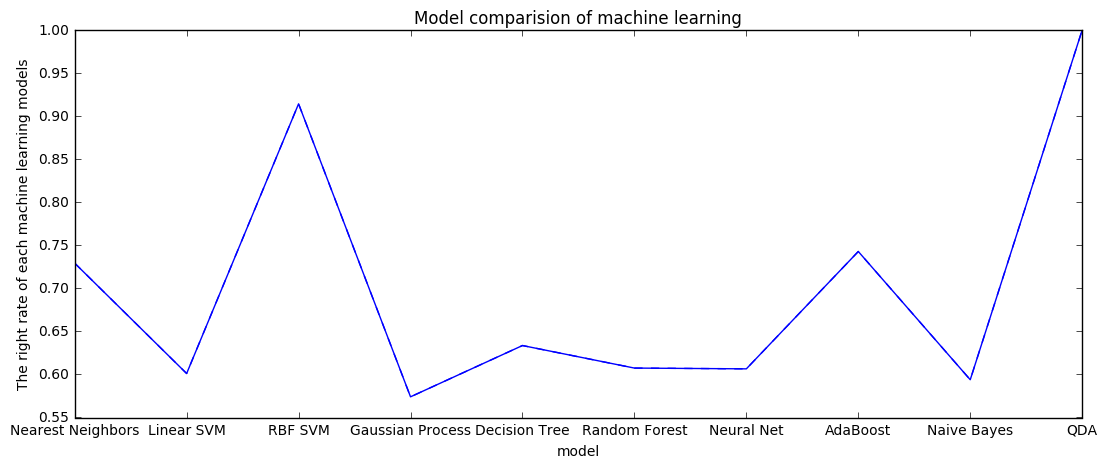

In [86]:
print (score)
plt.figure(figsize=(13,5)) 
plt.plot(range(len(score)),score,"b--",linewidth=1)      
plt.xlabel("model") 
plt.ylabel("The right rate of each machine learning models")  
plt.title("Model comparision of machine learning") 
plt.xticks(range(len(score)), names )
plt.plot(range(len(score)),score)

Now we can see that different machine learning models varies a lot in this problem.The RBF SVM and QDA have a good result.We can see the contrast between machine learning models and graph theroy models.

---

### 3. Network Graphs for Mackbook and surface related products comparison

- Our data preparation notebook for generating network graphs can be accessed with the following link:

https://nbviewer.jupyter.org/gist/xiangzhemeng/deb2495e7f9af7953d69859216aee7b8

- Our network graph is shown in this page:

https://xiangzhemeng.github.io/ntds/index.html

---
## Study on Macbook, Surface and ThinkPad

In [60]:
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

Load the data.

In [61]:
df_product_title = pd.read_pickle('data/product_with_title.pkl')
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

Find the `also_bought` products of list of products.

In [62]:
def get_all_related_asin_from_list_asin(list_asin):
    res = []
    for asin in list_asin:
        res.extend(df_product.loc[asin]['also_bought'])
    res = list(set(res))
    return res

In [63]:
# Macbook
nb_layer = 2
df_mac = df_product[df_product.index == 'B005CWJB5G']
list_asin = ['B005CWJB5G']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_mac = pd.concat([df_mac,df_product.loc[index]])
    list_asin = index
df_mac = df_mac.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of mac.'.format(df_mac.shape[0]))

We have 743 products in the group of mac.


In [64]:
# Surface
nb_layer = 2
df_surface = df_product[df_product.index == 'B00FG7MVJU']
list_asin = ['B00FG7MVJU']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_surface = pd.concat([df_surface,df_product.loc[index]])
    list_asin = index
df_surface = df_surface.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of surface.'.format(df_surface.shape[0]))

We have 499 products in the group of surface.


In [65]:
# ThinkPad
nb_layer = 2
df_think = df_product[df_product.index == 'B00JP7OGQ8']
list_asin = ['B00JP7OGQ8']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_think = pd.concat([df_think,df_product.loc[index]])
    list_asin = index
df_think = df_think.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of ThinkPad.'.format(df_think.shape[0]))

We have 574 products in the group of ThinkPad.


In [66]:
# FORMER CODE
# Find the duplicated products among three groups.

dupasin_mac_surface = list(set(df_mac.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in Mac and Surface.'.format(len(dupasin_mac_surface)))
dupasin_mac_think = list(set(df_mac.asin.values) & set(df_think.asin.values))
print('We have {} duplicate products in Mac and ThinkPad.'.format(len(dupasin_mac_think)))
dupasin_think_surface = list(set(df_think.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in ThinkPad and Surface.'.format(len(dupasin_think_surface)))

dupasin = list(set(df_think.asin.values) & set(df_surface.asin.values) & set(df_mac.asin.values))
print('We have {} duplicate products.'.format(len(dupasin)))

We have 134 duplicate products in Mac and Surface.
We have 148 duplicate products in Mac and ThinkPad.
We have 141 duplicate products in ThinkPad and Surface.
We have 80 duplicate products.


In [67]:
df_think_surface = pd.concat([df_think.reset_index(), df_surface])
df_think_mac = pd.concat([df_think.reset_index(), df_mac])
df_mac_surface = pd.concat([df_mac.reset_index(), df_surface])

# distinct mac products
mac_duplicate = list(set(df_mac.asin.values) & set(df_think_surface.asin.values))
print('We have {} distinct products for Macbook.'.format(len(df_mac)-len(mac_duplicate)))
# distinct surface produ3cts
surface_duplicate = list(set(df_surface.asin.values) & set(df_think_mac.asin.values))
print('We have {} distinct products for Surface.'.format(len(df_surface)-len(surface_duplicate)))
# distincy thinkpad products
think_duplicate = list(set(df_think.asin.values) & set(df_mac_surface.asin.values))
print('We have {} distinct products for Thinkpad.'.format(len(df_think)-len(think_duplicate)))

We have 541 distinct products for Macbook.
We have 304 distinct products for Surface.
We have 365 distinct products for Thinkpad.


In [68]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
v=venn3(subsets = (541, 304, 54, 365, 68, 61, 80), set_labels = ('Mac', 'Surface', 'ThinkPad'))
plt.show()

ImportError: No module named 'matplotlib_venn'

We Only keep products distinct to one of the groups.

In [69]:
df_think_new = df_think[~df_think['asin'].isin(think_duplicate)]
df_mac_new = df_mac[~df_mac['asin'].isin(mac_duplicate)]
df_surface_new = df_surface[~df_surface['asin'].isin(surface_duplicate)]

In [70]:
df_all_new = pd.concat([df_think_new.reset_index(), df_mac_new, df_surface_new])
print('We have {} products in all.'.format(df_all_new.shape[0]))

We have 1210 products in all.


In [71]:
df_all_new.head()

,also_bought,asin,index
0,"[B002HZW7D4, B00DBV28TG, B002J9HBIO, B005QXX0M...",B00JP7OGQ8,0.0
1,"[B00JP7OGQ8, B009PHTHRG, B00F3ZNTVO, B00F3ZNR1...",B002HZW7D4,1.0
2,"[B007FGH6WM, B0088PUEPK, B00H09BOXQ, B0028H1G9...",B00E3RH5W2,3.0
3,"[B00DXWFF3E, B00GZ1WXAI, B00GZUKNJM, B00DPPOI5...",B002J9HBIO,4.0
4,"[B00684PN54, B00006B7SG, B000FKP55K, B007EYY3X...",B000F4TCDM,5.0


### Build the graph
Same as before, we use the data we selected above (in df_all_new) to build the product graph.

- **Node**: Product


- **Edge**: If A is the 'also_bought' of B or B is the 'also_bought' of A, connect A and B.


- **Weight**: Below we implement two ways to calculate the weight of edge.

    - Use only the information of 'also_bougtht': $$Weight = \# Shared\_Neighbors$$
    
    - Use both the information of 'also_bougtht' and 'reviewer':$$Weight = 0.8 * \frac{\# Shared\_Neighbors}{MaxShared\_Neighbors} + 0.2 * \frac{\# Shared\_Reviewers}{MaxShared\_Neighbors}$$
    
    
- **Similarity**: For the implementation of spectral graph theory, we also need define the similarity between two products. The similarity is calculated as below:
$$Similarity = \frac{Weight}{MaxWeight}$$

### 2.1.  Use only the information of 'also_bought'

In [72]:
G = nx.Graph()
G.add_nodes_from(df_all_new.asin.values)

In [73]:
for i in range(len(df_all_new)):
    for j in range(i+1, len(df_all_new)):
        set_len = len(set(df_all_new.iloc[i]['also_bought'])&set(df_all_new.iloc[j]['also_bought']))
        G.add_edge(df_all_new.iloc[i]['asin'], df_all_new.iloc[j]['asin'], weight=set_len)

In [74]:
A = nx.adjacency_matrix(G,weight='weight')
A.todense()

matrix([[0, 0, 1, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 5, 1],
        [1, 0, 0, ..., 0, 1, 1],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 5, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

### **`Spectral Graph Theory`**

Calculate the **Similarity Matrix** by normalizing the maximum as 1

In [20]:
A.max()

47

In [21]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

Keep the **TOP K Neighbors**.

We first use K = 300.

In [22]:
weights = similar.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

In [23]:
weights

array([[ 0.        ,  0.0212766 ,  0.0212766 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0212766 ,  0.        ,  0.04255319, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0212766 ,  0.04255319,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.04255319,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.04255319,
         0.        ,  0.0212766 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.0212766 ,  0.        ]])

Calculate the **Laplacian**.

In [24]:
degrees = np.sum(weights, axis=0)+0.0001
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))

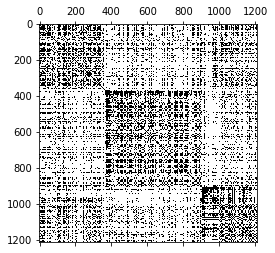

In [25]:
plt.spy(laplacian)
plt.show()

**Eigenvalue decomposition** of the Laplacian.

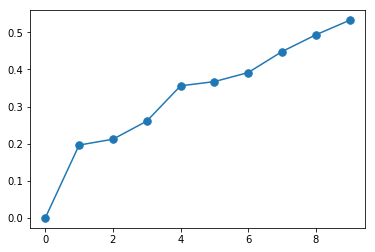

In [26]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Ground truth**: we label all of data in think_pad group as 0, surface group as 1 and mac group as 2.

In [89]:
labels = np.ones(A.shape[0])
labels[0:len(df_think_new)] = 0
labels[len(df_think_new):len(df_think_new)+len(df_mac_new)] = 1
labels[len(df_think_new)+len(df_mac_new):len(df_think_new)+len(df_mac_new)+len(df_surface_new)] = 2

**Plot** the groud truth and the prediction based on spectral graph theory.

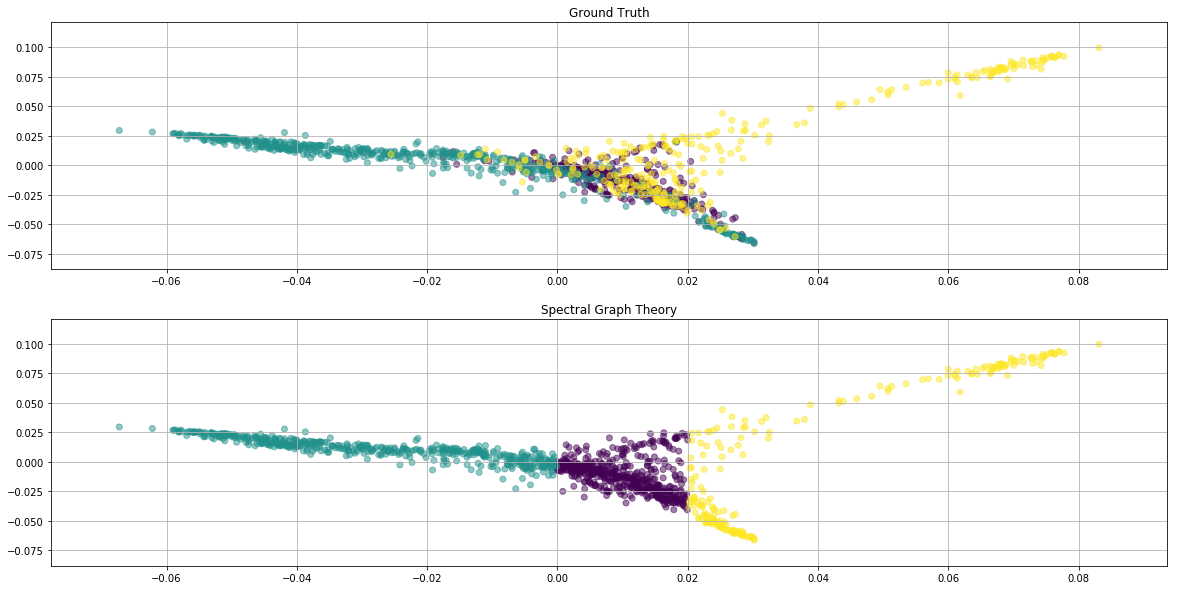

In [37]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]

colorList = list()
for i in x1:
    if i < 0:
        colorList.append(1)
    elif i > 0.02:
        colorList.append(2)
    else:
        colorList.append(0)
        
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=colorList, alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error rate**

In [38]:
np.sum(colorList != labels)/len(labels)

0.29586776859504132

In [87]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.25),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
i = 1
score=[]
error=[]

In [90]:
X, y = np.array(A.todense()),np.array(labels)
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X, y)
    score.append(clf.score(X, y))
    names.append(name)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.62314049586776854, 1.0, 1.0, 1.0, 0.484297520661157, 0.46859504132231405, 0.74545454545454548, 0.53884297520661162, 0.49090909090909091, 1.0]


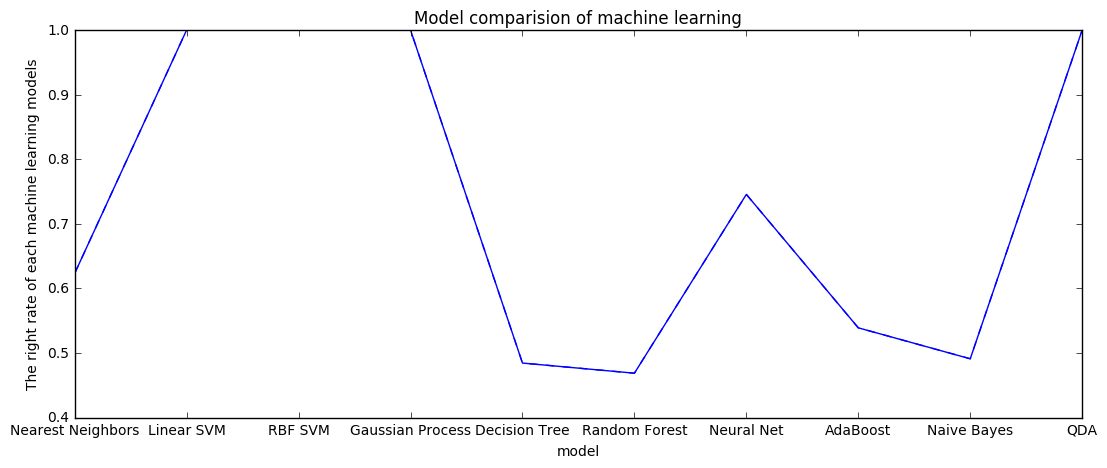

In [91]:
print (score)
plt.figure(figsize=(13,5)) 
plt.plot(range(len(score)),score,"b--",linewidth=1)      
plt.xlabel("model") 
plt.ylabel("The right rate of each machine learning models")  
plt.title("Model comparision of machine learning") 
plt.xticks(range(len(score)), names )
plt.plot(range(len(score)),score)

From the test, we can see no matter how many categories we have , QDA is a really good way to substitute the graph classification. Also, SVM can achieve a good result.

### **`Transductive Learning`**

In [219]:
# Ground truth.
x = np.ones(len(G.nodes))
x[0:len(df_think_new)] = -1
x[len(df_think_new):len(df_think_new)+len(df_mac_new)] = 1
x[len(df_think_new)+len(df_mac_new):len(df_think_new)+len(df_mac_new)+len(df_surface_new)] = 3

# x[0:n_mac] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=len(G.nodes)) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)

In [220]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    
    M = np.diag(y!=0)
    
    x_star = np.linalg.solve(M+alpha*laplacian, M.dot(y))
    
    x_pred = np.ones(len(G.nodes))
    for i in range(len(x_star)):
        if x_star[i] < 0:
            x_pred[i] = -1
        elif x_star[i] > 0 and x_star[i] < 2:
            x_pred[i] = 1
        else:
            x_pred[i] = 3
    
    return x_pred, x_star

x_pred, x_star = solve(y, alpha=1)

# Error rate.
#err = np.sum(np.abs(x - x_pred))
err = np.sum(x != x_pred)
print('{} errors ({:.2%})'.format(err, err/len(G.nodes)))

621 errors (51.32%)


In [221]:
alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y = prepare_observations(p)
    x_pred, _ = solve(y, alpha)
    err = np.sum(x != x_pred)
    print('{}: {:6.2%}'.format(p, err/len(G.nodes)))

0.1: 49.09%
0.3: 34.21%
0.5: 24.55%
0.7: 13.64%
0.9:  4.63%


**Plot**

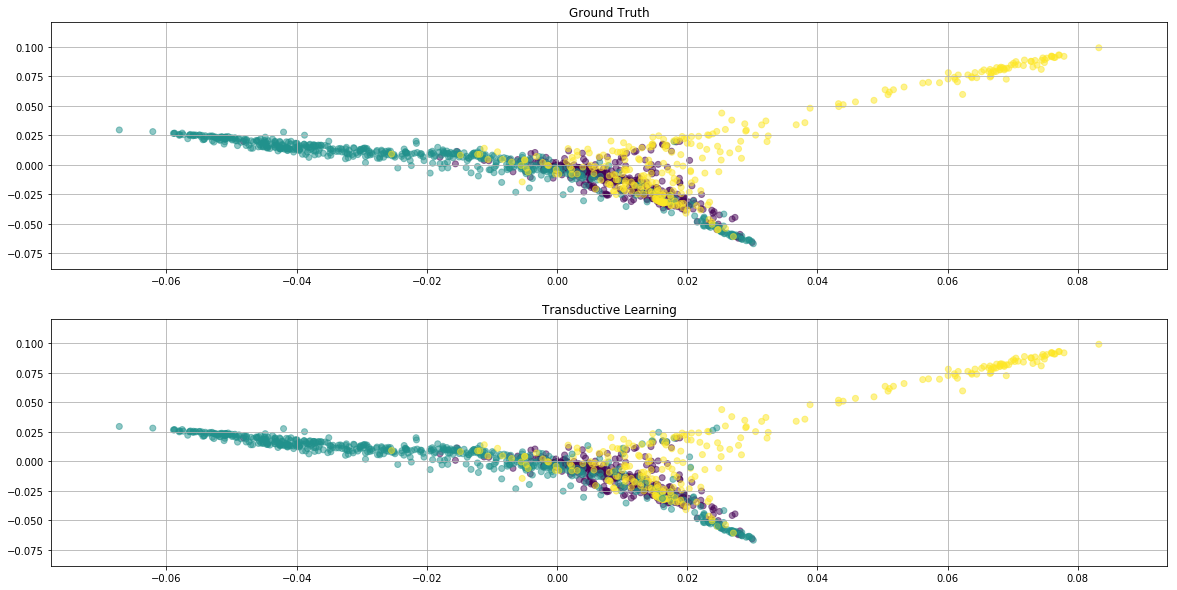

In [222]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=x_pred, alpha=0.5)
ax[1].set_title('Transductive Learning')
ax[1].grid()

### 2.2. Use both the information of 'also_bought' and 'reviewer'

In [101]:
df_review.head()

,reviewerID
asin,
B0083S3NC8,"[A18I2DO90GZCQY, A2C4BO8UURNWNN, A2RF9FHC4HC3J..."
B0047FHOWG,"[A3OTFTP2WVZVQY, A10KIQXOE926FN, A1Q165PZVZS34..."
B0067SJC80,"[A3QLALFN0WGF87, A395EVHF1TAQN0, AOEDXOKYPII2Z..."
B002WQP2IA,"[AN3ILH8NOGNH4, A3FGRP5N72WES1, ADN4437IJDIPP,..."
B006IC4YZQ,"[A3W3PWGZ36249Y, AZLDKR28KT3FB, A3M3DL4G9NS3Z2..."


Select the review information of data in our DataFrame.

In [102]:
df_review_chosen = df_review.loc[df_all_new.asin].reset_index()

Build the graph as we did above.

In [103]:
GB = nx.Graph()
GB.add_nodes_from(df_all_new.asin.values)
bou_len_list = [] # list for # shared also_bought
rer_len_list = [] # list for # shared reviewer

for i in range(len(df_all_new)):
    for j in range(i+1, len(df_all_new)):
        bou_len_list.append(len(set(df_all_new.iloc[i]['also_bought'])&set(df_all_new.iloc[j]['also_bought'])))
        rer_len_list.append(len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID'])))

In [104]:
# Study the basics of two lists
df_bou_rer = pd.DataFrame({'b': bou_len_list, 'r': rer_len_list})
pd.DataFrame([df_bou_rer[df_bou_rer.b>0].describe().b, df_bou_rer[df_bou_rer.r>0].describe().r])

,count,mean,std,min,25%,50%,75%,max
b,263493.0,3.520644,3.996601,1.0,1.0,2.0,4.0,47.0
r,41234.0,1.660305,2.198098,1.0,1.0,1.0,2.0,116.0


In [105]:
bou_len_list.reverse()
rer_len_list.reverse()
for i in range(len(df_all_new)):
    for j in range(i+1, len(df_all_new)):
        bou_len = bou_len_list.pop()/47
        rer_len = rer_len_list.pop()/211
        # The weight is manually chosen now and may need to be modified
        GB.add_edge(df_all_new.iloc[i]['asin'], df_all_new.iloc[j]['asin'], weight=0.8*bou_len+0.2*rer_len)

In [106]:
B = nx.adjacency_matrix(GB,weight='weight')
B.todense()

matrix([[ 0.        ,  0.        ,  0.01702128, ...,  0.        ,
          0.        ,  0.01702128],
        [ 0.        ,  0.        ,  0.00094787, ...,  0.        ,
          0.08794998,  0.01891701],
        [ 0.01702128,  0.00094787,  0.        , ...,  0.        ,
          0.01702128,  0.01702128],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.08794998,  0.01702128, ...,  0.        ,
          0.        ,  0.00094787],
        [ 0.01702128,  0.01891701,  0.01702128, ...,  0.        ,
          0.00094787,  0.        ]])

### `Spectral Graph Theory`

**Similarity Matrix**

In [230]:
B.max()

0.80000000000000004

In [231]:
similarB = B.todense()/B.max()
np.fill_diagonal(similarB,0)

**TOP K Neighbors**

In [232]:
weights = similarB.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

**Calculate Laplacian**

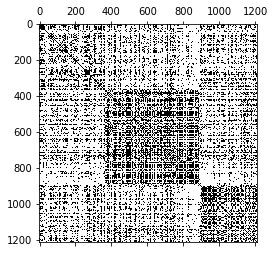

In [233]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue Decomposition**

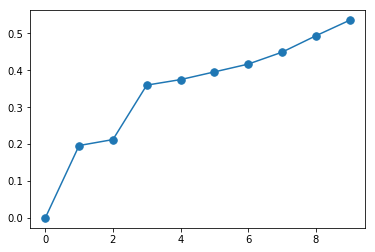

In [234]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Plot**

In [237]:
labels = np.ones(B.shape[0])
labels[0:len(df_think_new)] = 0
labels[len(df_think_new):len(df_think_new)+len(df_mac_new)] = 1
labels[len(df_think_new)+len(df_mac_new):len(df_think_new)+len(df_mac_new)+len(df_surface_new)] = 2

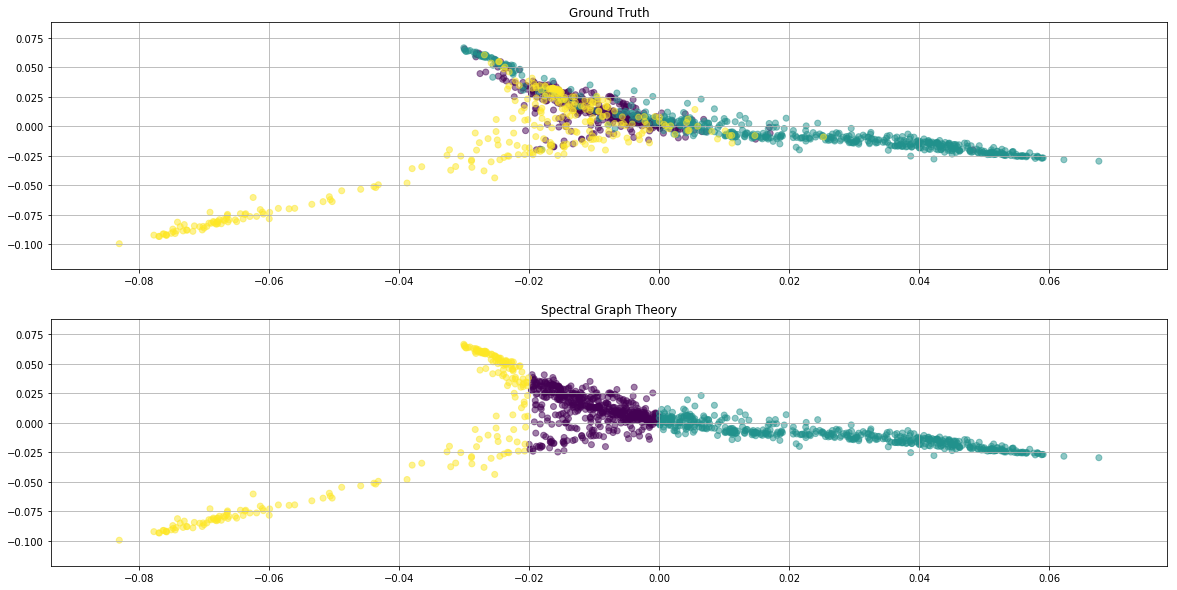

In [259]:
x2 = eigenvectors[:,1]
y2 = eigenvectors[:,2]

colorList = list()
for i in x2:
    if i < -0.02:
        colorList.append(2)
    elif i > 0:
        colorList.append(1)
    else:
        colorList.append(0)

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x2, y2, c=labels, alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x2, y2, c=colorList, alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error Rate**

In [260]:
np.sum(colorList != labels)/len(labels)

0.29504132231404961

In [107]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.25),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
i = 1
score=[]
error=[]

In [108]:
X, y = np.array(B.todense()),np.array(labels)
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X, y)
    score.append(clf.score(X, y))
    names.append(name)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.62148760330578512, 0.44710743801652891, 0.83801652892561984, 0.44710743801652891, 0.4900826446280992, 0.46942148760330576, 0.44793388429752068, 0.55371900826446285, 0.49173553719008267, 1.0]


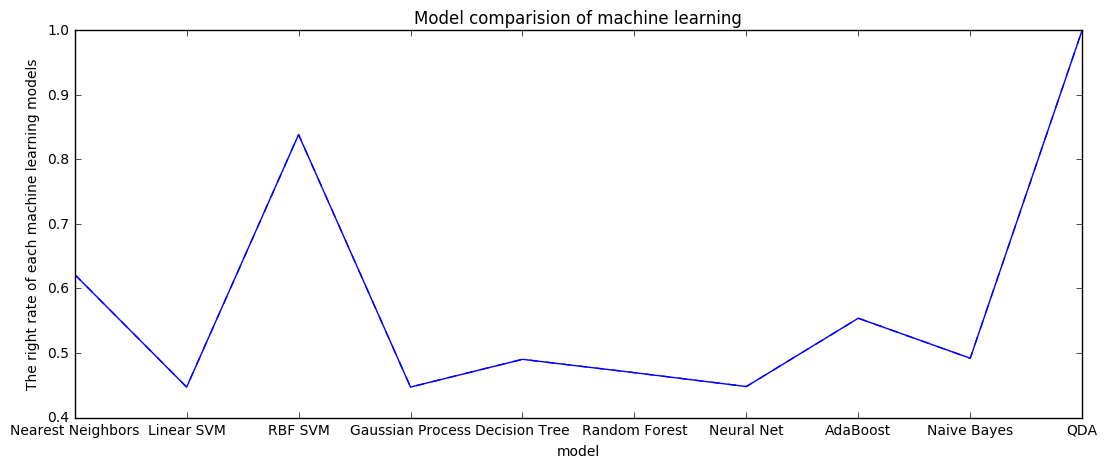

In [109]:
print (score)
plt.figure(figsize=(13,5)) 
plt.plot(range(len(score)),score,"b--",linewidth=1)      
plt.xlabel("model") 
plt.ylabel("The right rate of each machine learning models")  
plt.title("Model comparision of machine learning") 
plt.xticks(range(len(score)), names )
plt.plot(range(len(score)),score)